# Setup

In [ ]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

# from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import itertools
from random import randint

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors   
import numpy as np
import os

import shap
import cv2

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

from exmatchina import *

import random
random.seed(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

2025-07-04 19:48:55.572156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-04 19:48:56.285261: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-07-04 19:48:56.285353: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-07-04 19:48:56.285360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [31]:
num_classes = 95

sample_length = 300
# classes = ['Non-ecotic beats (normal beat)', 
#            'Supraventricular ectopic beats', 
#            'Ventricular ectopic beats', 
#            'Fusion beats', 
#            'Unknown beats']


# class_dict = {
#     'Non-ecotic beats (normal beat)': 0,
#     'Supraventricular ectopic beats': 1,
#     'Ventricular ectopic beats': 2,
#     'Fusion beats': 3,
#     'Unknown beats': 4
# }

# inv_class_dict = {v: k for k, v in class_dict.items()}

classes = list(range(num_classes))

## These are the randomly generated indices that were used in our survey

# all_idx = np.array([   86,   228,   692,  1157,  1244,  1264,  1656,  2432,  2777,
#         2925,  3016,  3108,  3167,  3335,  4184,  4607,  4723,  4999,
#         5840,  6081,  6123,  6130,  6206,  6228,  6294,  6515,  6567,
#         6598,  6726,  6877,  6973,  7033,  7410,  7426,  7540,  8042,
#         8220,  8439,  8609,  8766,  8855,  9437,  9442,  9517,  9719,
#        10026, 10345, 10511, 10588, 10623, 10807, 11290, 11367, 11909,
#        12009, 12088, 12534, 12760, 12986, 13311, 13352, 13477, 13561,
#        13659, 13904, 14087, 14257, 14455, 14596, 14852, 14962, 15103,
#        15715, 15820, 16830, 16860, 17142, 17154, 17356, 17382, 17451,
#        17520, 17845, 17882, 17944, 18354, 18557, 18630, 18666, 19032,
#        19199, 19531, 19932, 20399, 20618, 20636, 20782, 20844, 20849,
#        21857])

all_idx = [0, 1, 2, 3, 4]      #Considering just 5 samples

In [32]:
from data_loader import load_npz_split
x_train0, y_train0, x_valid0, y_valid0, x_test0, y_test0 = load_npz_split('/home/kwakrhkr59/XAI_WF/dataset/nodef/bigenough_original_all.npz')
x_train1, y_train1, x_valid1, y_valid1, x_test1, y_test1 = load_npz_split('/home/kwakrhkr59/XAI_WF/dataset/nodef/bigenough_direction_all.npz')

Configured NB_CLASSES (75) does not match actual number of classes (95). Using 95.
Configured NB_CLASSES (75) does not match actual number of classes (95). Using 95.


In [33]:
print(np.sign(x_test0[:, :, 1]))

[[-1. -1.  1. ...  0.  0.  0.]
 [-1. -1.  1. ...  0.  0.  0.]
 [-1. -1.  1. ... -1. -1. -1.]
 ...
 [-1. -1.  1. ... -1. -1. -1.]
 [-1. -1.  1. ...  0.  0.  0.]
 [-1. -1.  1. ...  0.  0.  0.]]


In [34]:
print(x_test1)

[[-1. -1.  1. ...  0.  0.  0.]
 [-1. -1.  1. ... -1. -1. -1.]
 [-1. -1.  1. ...  0.  0.  0.]
 ...
 [-1. -1.  1. ...  1. -1. -1.]
 [-1. -1.  1. ...  0.  0.  0.]
 [-1. -1.  1. ...  0.  0.  0.]]


In [35]:
model = load_model(f'/home/kwakrhkr59/XAI_WF/attack/df/models/DF_bigenough_nodef_original_batch128_length{sample_length}_epoch50.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv1D)       (None, 300, 32)           288       
                                                                 
 batch_normalization (BatchN  (None, 300, 32)          128       
 ormalization)                                                   
                                                                 
 block1_adv_act1 (ELU)       (None, 300, 32)           0         
                                                                 
 block1_conv2 (Conv1D)       (None, 300, 32)           8224      
                                                                 
 batch_normalization_1 (Batc  (None, 300, 32)          128       
 hNormalization)                                                 
                                                                 
 block1_adv_act2 (ELU)       (None, 300, 32)           0

In [36]:
def calculate_metrics(model, X_test, y_test_binary):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test_binary, axis=1)
    mismatch = np.where(y_true != y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return cf_matrix, accuracy, macro_f1, mismatch, y_pred

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        # print(cm)
    else:
        print('Confusion matrix, without normalization')
        # print(cm)

    plt.figure(figsize = (11,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 1)
    plt.yticks(tick_marks, classes, fontsize = 1)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 1,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
  
    plt.show()

60/60 [==============================] - 1s 5ms/step
Accuracy : 0.9263157894736842
F1-score : 0.9262177934427193
Normalized confusion matrix


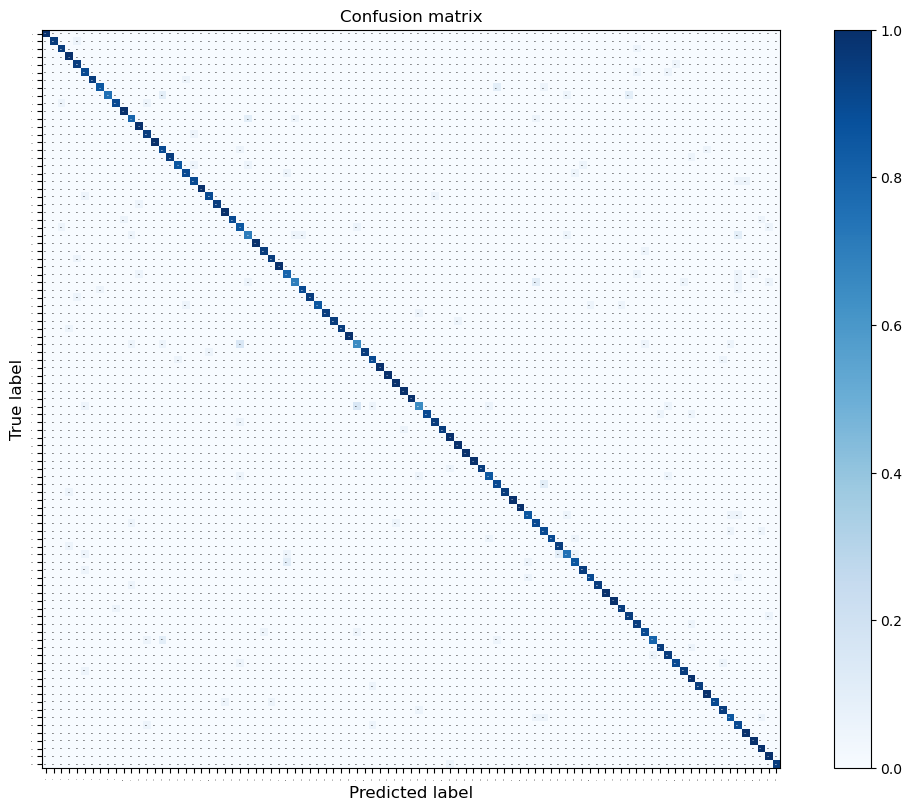

In [37]:
cf_matrix, accuracy, macro_f1, mismatch, y_pred = calculate_metrics(model, x_test0[:,:sample_length,1], y_test0)
print('Accuracy : {}'.format(accuracy))
print('F1-score : {}'.format(macro_f1))

plot_confusion_matrix(cf_matrix, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [38]:
x_train = x_train0[:,:sample_length,1]
x_test = x_test0[:,:sample_length,1]

In [39]:
print(x_train.shape, x_test.shape)

(15200, 300) (1900, 300)


# SHAP

In [49]:
# background = x_train0[np.random.choice(x_train0.shape[0], 5000, replace=False)]
background = x_train0
background = np.expand_dims(background[:,:sample_length,1], axis=-1)
background.shape

(15200, 300, 1)

In [50]:
import tensorflow.keras.backend as K
# def map2layer(x, layer):
#     feed_dict = dict(zip([model.layers[0].input], x.reshape((1,) + x.shape)))
#     return K.get_session().run(model.layers[layer].input, feed_dict)
def map2layer(x, layer):
    if x.ndim == 3:  # (batch, 186, 1)
        x_in = x
    elif x.ndim == 2:  # (186, 1)
        x_in = np.expand_dims(x, axis=0)
    else:
        raise ValueError(f'Unexpected input shape: {x.shape}')
    
    func = K.function([model.input], [model.layers[layer].input])
    return func([x_in])[0]
    
def get_shap_full():
    e = shap.GradientExplainer(model, background)
    shap_values = e.shap_values(to_explain, ranked_outputs=2)
    shap.image_plot(shap_values, to_explain, width=5000, hspace='auto')


In [51]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((0/255,255/255,255/255,l))
for l in np.linspace(0,1,100):
    colors.append((255/255,0/255,255/255,l))
cmm = matplotlib.colors.LinearSegmentedColormap.from_list("shap", colors)

# # def plot_shap(idx):
    
# #     layer = 9
# #     to_explain = np.expand_dims(x_test[idx], axis=0)
# #     class_pred = np.argmax(model.predict(to_explain))
# #     print(class_pred)
    
# #     e = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(background, layer))
# #     shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=1)
# # plot_shap 함수 내부 수정
# def plot_shap(idx):
#     layer = 9
    
#     # x_test[idx]의 원래 shape을 확인해야 합니다.
#     # 만약 x_test[idx]가 (5000,) 형태라면,
#     # to_explain = np.expand_dims(x_test[idx], axis=(0, -1))
#     # 이렇게 하면 (1, 5000, 1)이 됩니다.
    
#     # 만약 x_test[idx]가 (5000, N) 형태인데 N이 1이 아니라면,
#     # 예를 들어 x_test[idx]가 (5000, 2)이고 두 번째 feature만 사용한다면,
#     # to_explain = np.expand_dims(x_test[idx][:, 1], axis=(0, -1))
    
#     # 현재 코드에서는 x_test = x_test0[:,:,1] 가 주석 처리되어 있을 것이므로,
#     # x_test는 x_test0와 동일하다고 가정하고, x_test0가 (samples, 5000, features) 형태라고 가정합니다.
#     # 이때, to_explain은 (1, 5000, 1)이 되어야 하므로, features 차원에서 원하는 인덱스를 선택해야 합니다.
    
#     # 예시: x_test0가 (samples, 5000, K) 이고, K가 1이라면
#     to_explain = x_test[idx:idx+1, :, :] # (1, 5000, 1)

#     # 예시: x_test0가 (samples, 5000, K) 이고, K > 1이며 특정 feature만 필요하다면
#     # 예를 들어 두 번째 feature (인덱스 1)을 사용하고 싶다면:
#     # to_explain = x_test[idx:idx+1, :, 1:2] # (1, 5000, 1)
    
#     # 만약 x_test가 (samples, 5000) 형태 (즉, 마지막 feature 차원이 이미 제거된 상태)라면:
#     # to_explain = np.expand_dims(x_test[idx], axis=(0, -1)) # (1, 5000, 1)
#     # 이 경우, plot_shap 하단의 ax[0].plot(x_test[idx, :, 0], ...) 부분도 x_test[idx]만 사용해야 합니다.

#     # 일반적으로 (samples, timesteps, features) 형태를 유지하려면 아래와 같이 사용할 수 있습니다.
#     # 이전에 x_train = x_train0, x_test = x_test0 로 설정했다면,
#     # to_explain = x_test[idx:idx+1] # (1, 5000, 1)
#     # 만약 x_test0[:,:,1]을 사용하고 싶다면, plot_shap에서 이 부분을 다시 조정해야 합니다.
    
#     # 가장 확실한 방법은 plot_shap 함수 시작 부분에서 to_explain을 (1, 5000, 1)로 강제 변환하는 것입니다.
#     # 예를 들어, `x_test`가 `(samples, 5000)` 형태라고 가정할 때:
#     to_explain = np.expand_dims(x_test[idx], axis=(0, -1)) # (1, 5000, 1)
#     # 또는 x_test가 (samples, 5000, 1) 형태를 가정할 때:
#     # to_explain = np.expand_dims(x_test[idx], axis=0) # (1, 5000, 1)
    
#     # 어떤 방식이든 to_explain이 (1, 5000, 1)이 되는지 확인해야 합니다.
#     print(f"Shape of to_explain before map2layer: {to_explain.shape}") # 디버깅용
    
#     class_pred = np.argmax(model.predict(to_explain))
#     print(class_pred)
    
#     e = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(background, layer))
#     shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=1)

#     # ... (나머지 코드 동일)
#     abs_vals = np.stack(np.abs(shap_values[0].sum(-1)), 0).flatten()
#     max_val = np.nanpercentile(abs_vals, 99.9)

#     shap_values = cv2.resize(shap_values[0][0].sum(-1), (1,186))
#     shap_values = shap_values.reshape((186,1))

#     fig, ax = plt.subplots(ncols=2, figsize=(12,5))

#     ax[0].plot(x_test[idx, :, 0], color='black')

#     ax[1].plot(x_test[idx,:,0], color='black')

#     gradient = shap_values[:,0]
#     max_g = np.amax(gradient)
#     min_g = np.amin(gradient)
#     gradient = (gradient - min_g)/ (max_g - min_g)

#     for j in range(len(gradient)):
#         current_color = cmm(gradient[j])
#         ax[1].axvspan(j, j+1, facecolor=current_color)   

#     sm = cm.ScalarMappable(cmap=cmm)
#     sm.set_clim(-max_val,max_val)

#     cb = fig.colorbar(sm, ax=ax.ravel().tolist(), label="SHAP value", aspect=60)
#     cb.outline.set_visible(False)

#     # plt.savefig('./ecg/ecg-' + str(idx) + '-shap.png', bbox_inches='tight')
#     # plt.close(fig)
#     plt.show()

In [91]:
def plot_shap(idx):
    layer = 18
    to_explain = np.expand_dims(x_test[idx], axis=(0, -1))
    print(f"Shape of to_explain before map2layer: {to_explain.shape}")

    class_pred = np.argmax(model.predict(to_explain))
    print(class_pred)

    e = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output), map2layer(background, layer))
    shap_values,indexes = e.shap_values(map2layer(to_explain, layer), ranked_outputs=1)

    abs_vals = np.stack(np.abs(shap_values[0].sum(-1)), 0).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)

    shap_values = cv2.resize(shap_values[0][0].sum(-1), (1, 5000))
    shap_values = shap_values.reshape((5000,1))

    # fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    fig, ax = plt.subplots(figsize=(8, 4)) 

    start_point = 0
    end_point = sample_length

    display_data = x_test[idx][start_point:end_point]
    x_coords = np.arange(len(display_data)) 

    # ax[0].bar(x_coords, display_data, color='black', width=1.0)
    # ax[1].bar(x_coords, display_data, color='black', width=1.0)
    ax.bar(x_coords, display_data, color='black', width=1.0)

    gradient = shap_values[:,0]
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g) / (max_g - min_g)

    for j in range(start_point, end_point):
        current_color = cmm(gradient[j])
        # ax[1].axvspan(j - start_point, j + 1 - start_point, facecolor=current_color)
        ax.axvspan(j - start_point, j + 1 - start_point, facecolor=current_color)

    # ax[0].set_xlim(0, end_point - start_point)
    # ax[1].set_xlim(0, end_point - start_point)
    ax.set_xlim(0, end_point - start_point)

    sm = cm.ScalarMappable(cmap=cmm)
    sm.set_clim(-max_val,max_val)

    # cb = fig.colorbar(sm, ax=ax.ravel().tolist(), label="SHAP value", aspect=60)
    cb = fig.colorbar(sm, ax=ax, label="SHAP value", aspect=60)
    cb.outline.set_visible(False)

    plt.show()

Shape of to_explain before map2layer: (1, 300, 1)
1/1 [==============================] - 0s 24ms/step
89


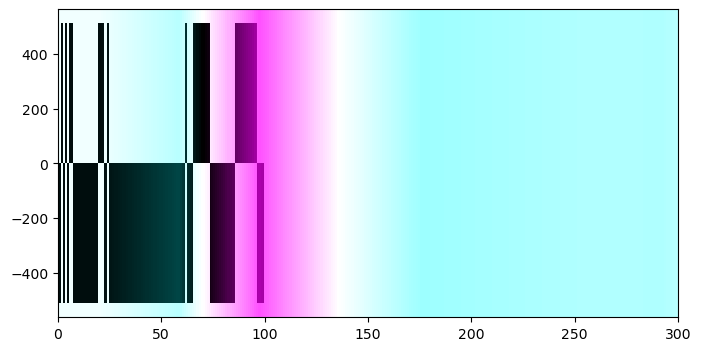

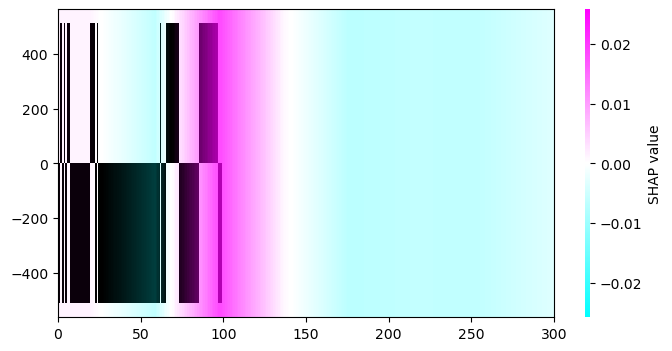

Shape of to_explain before map2layer: (1, 300, 1)
1/1 [==============================] - 0s 25ms/step
79


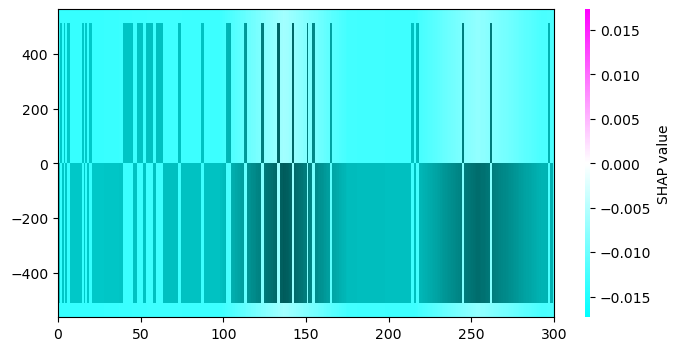

Shape of to_explain before map2layer: (1, 300, 1)
1/1 [==============================] - 0s 24ms/step
5


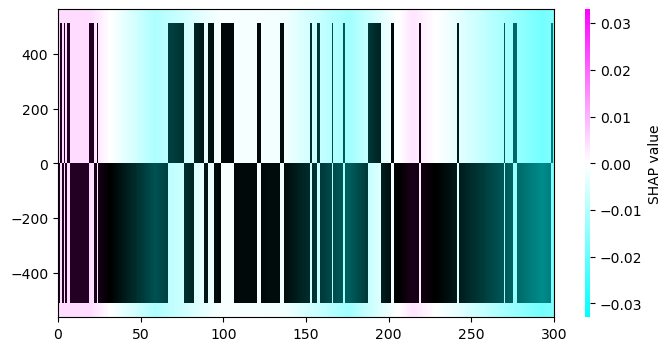

Shape of to_explain before map2layer: (1, 300, 1)
1/1 [==============================] - 0s 23ms/step
88


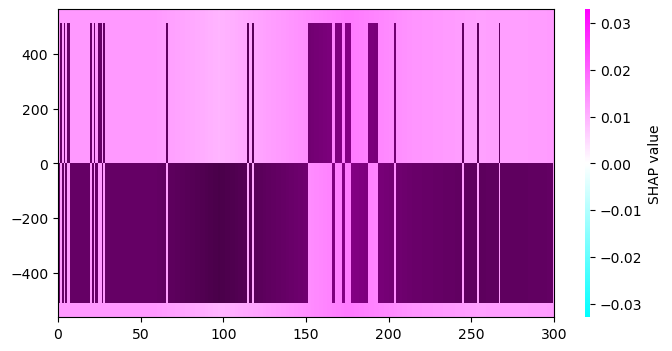

Shape of to_explain before map2layer: (1, 300, 1)
1/1 [==============================] - 0s 23ms/step
6


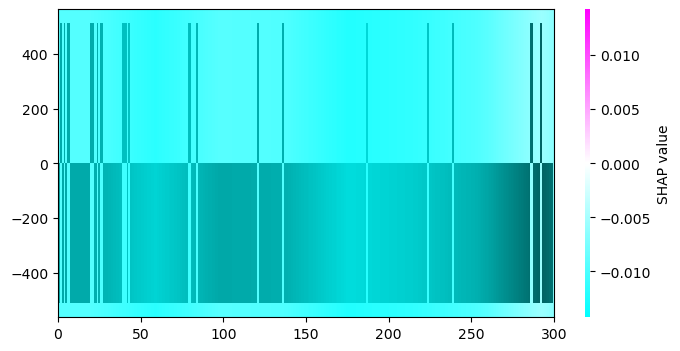

In [92]:
for i in all_idx:
    plot_shap(i)

# Saliency Map

In [93]:
# Saliency map requires the logits
new_model = Model(inputs=model.input,
                  outputs=model.get_layer("fc3").output)

new_model.summary()

Model: "model_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1_input (InputLa  [(None, 300, 1)]         0         
 yer)                                                            
                                                                 
 block1_conv1 (Conv1D)       (None, 300, 32)           288       
                                                                 
 batch_normalization (BatchN  (None, 300, 32)          128       
 ormalization)                                                   
                                                                 
 block1_adv_act1 (ELU)       (None, 300, 32)           0         
                                                                 
 block1_conv2 (Conv1D)       (None, 300, 32)           8224      
                                                                 
 batch_normalization_1 (Batc  (None, 300, 32)          12

In [97]:
def plot_map(idx, class_pred, grads):
    # fig, ax = plt.subplots(ncols=2, figsize=(8,4))
    fig, ax = plt.subplots(figsize=(8,4))
    
    start_point = 0
    end_point = sample_length

    display_data = x_test[idx][start_point:end_point]
    x_coords = np.arange(len(display_data)) 

    # ax[0].bar(x_coords, display_data, color='black', width=1.0)
    # ax[1].bar(x_coords, display_data, color='black', width=1.0)
    ax.bar(x_coords, display_data, color='black', width=1.0)

    gradient = grads
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for i in range(len(gradient)):
        current_color = cm.cool(gradient[i])
        # ax[1].axvspan(i, i+1, facecolor=current_color, alpha=0.7)
        ax.axvspan(i, i+1, facecolor=current_color, alpha=0.7)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
    fig.colorbar(cm.ScalarMappable(cmap="cool"), cbar_ax, alpha=0.8)
    
    # plt.savefig('./ecg/ecg-' + str(idx) + '-saliencymap.png', bbox_inches='tight')
    # plt.close(fig)
    plt.show()

In [98]:
def getSaliencyMap(idx):
    # to_explain = np.expand_dims(x_test[idx], axis=0)
    # class_pred = np.argmax(model.predict(to_explain))
    to_explain = np.expand_dims(x_test[idx], axis=(0, -1))
    print(to_explain.shape)
    class_pred = np.argmax(model.predict(to_explain))

    score = CategoricalScore([class_pred])
    modifier = ReplaceToLinear()

    saliency = Saliency(model, model_modifier=modifier)
    saliency_map = saliency(score, to_explain)

    saliency_map = saliency_map[0]
    if saliency_map.ndim == 2 and saliency_map.shape[1] == 1:
        saliency_map = saliency_map.reshape(-1)

    plot_map(idx, class_pred, saliency_map)

(1, 300, 1)
1/1 [==============================] - 0s 25ms/step


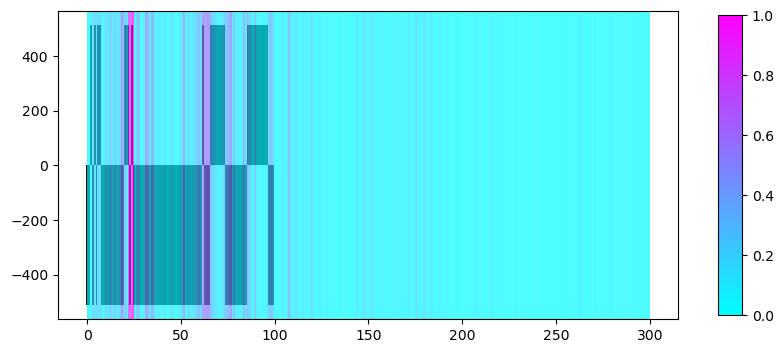

(1, 300, 1)
1/1 [==============================] - 0s 24ms/step


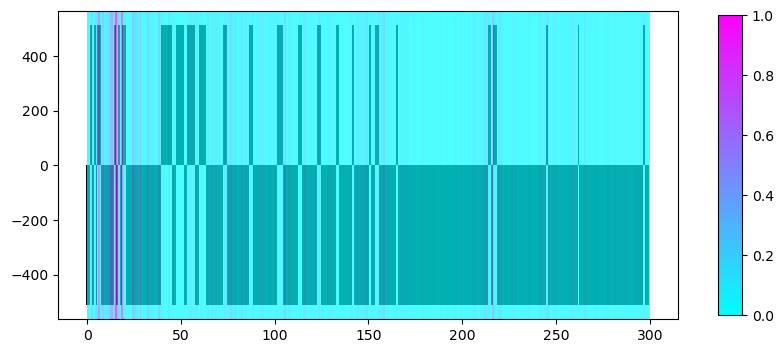

(1, 300, 1)
1/1 [==============================] - 0s 23ms/step


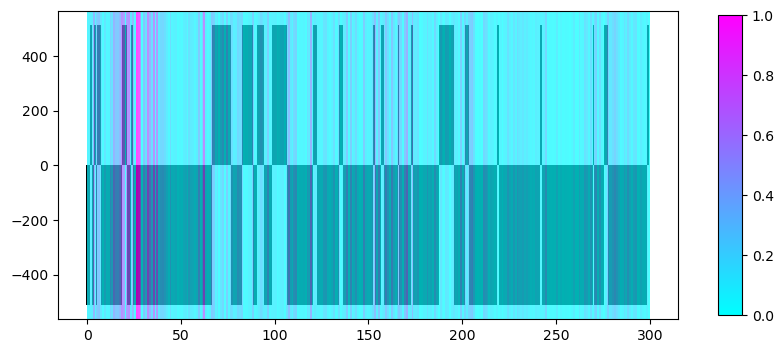

(1, 300, 1)
1/1 [==============================] - 0s 24ms/step


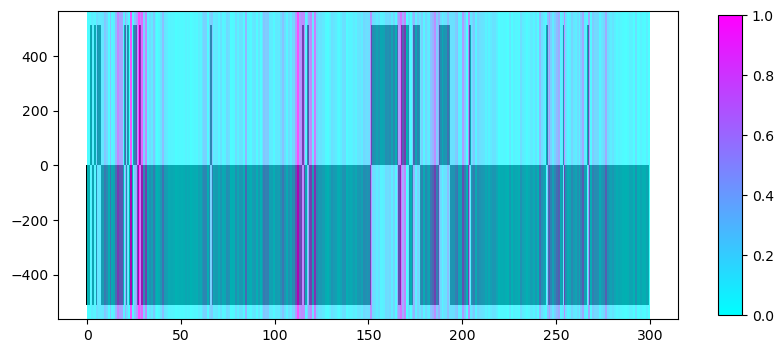

(1, 300, 1)
1/1 [==============================] - 0s 24ms/step


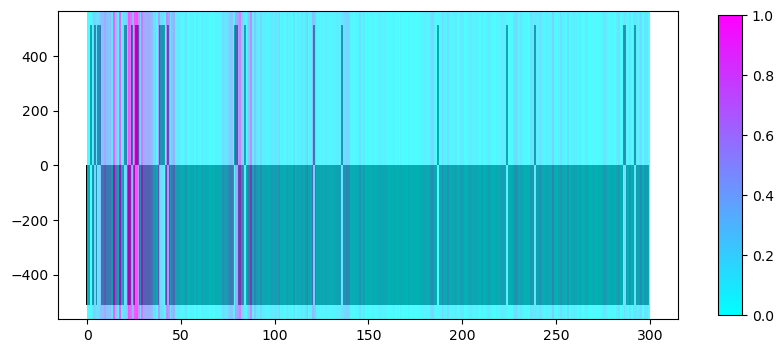

In [99]:
for i in all_idx:
    getSaliencyMap(i)

# GradCam++

In [110]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def plot_cam(idx, cls_pred, heatmap):
    # fig, ax = plt.subplots(ncols=2, figsize=(8,4))
    fig, ax = plt.subplots(figsize=(8,4))

    start_point = 0
    end_point = sample_length

    display_data = x_test[idx][start_point:end_point]
    x_coords = np.arange(len(display_data))

    ax.bar(x_coords, display_data, color='black', width=1.0)
    # ax[0].plot(x_test[idx, :, 0], color='black')
    # ax[1].plot(x_test[idx, :, 0], color='black')

    gradient = heatmap.reshape((300,))# gradient = heatmap.reshape((186,))
    max_g = np.amax(gradient)
    min_g = np.amin(gradient)
    gradient = (gradient - min_g)/ (max_g - min_g)

    for i in range(len(gradient)):
        current_color = cm.cool(gradient[i])
        # ax[1].axvspan(i, i+1, facecolor=current_color, alpha=0.7)
        ax.axvspan(i, i+1, facecolor=current_color, alpha=0.7)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
    fig.colorbar(cm.ScalarMappable(cmap="cool"), cbar_ax, alpha=0.8)

    # plt.savefig('./ecg/ecg-' + str(idx) + '-gradcampp.png', bbox_inches='tight')
    # plt.close(fig)
    plt.show()


def get_gradcampp(idx):
    img = x_test[idx]
    # x = np.expand_dims(img, axis=0)
    x = np.expand_dims(img, axis=(0, -1))

    class_idx = np.argmax(model.predict(x))  # 예측된 클래스 인덱스
    score = CategoricalScore([class_idx])    # tf-keras-vis용 score 함수

    gradcampp = GradcamPlusPlus(model, model_modifier=ReplaceToLinear())
    cam = gradcampp(score, x, penultimate_layer='block4_conv2')  # Conv3: 마지막 Conv 레이어 이름

    # cam.shape: (1, 186, 1) → (186, 1)
    heatmap = cam[0].squeeze()
    if heatmap.ndim == 1:
        # heatmap = heatmap.reshape((186, 1))
        heatmap = heatmap.reshape((300, 1))

    plot_cam(idx, class_idx, heatmap)


def grad_cam_plus_plus(input_model, x, layer_name):
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = normalize(K.gradients(y_c, conv_output)[0])

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[1])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[1]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))

    alphas = alpha_num / alpha_denom # 0

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[1])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[1])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=1)

    cam = np.maximum(cam, 0)
    if cam.max() == 0:
        print(idx)
    cam /= cam.max()

    return cls, cam

1/1 [==============================] - 0s 24ms/step


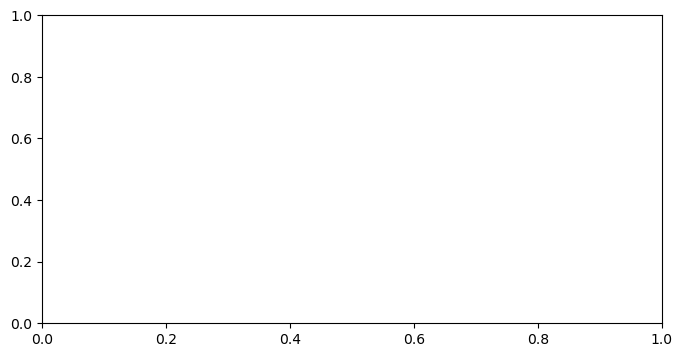

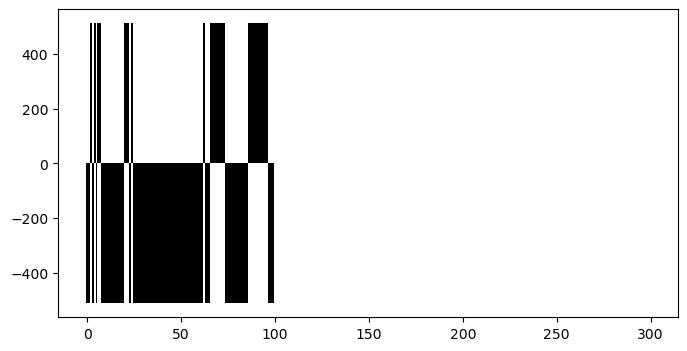

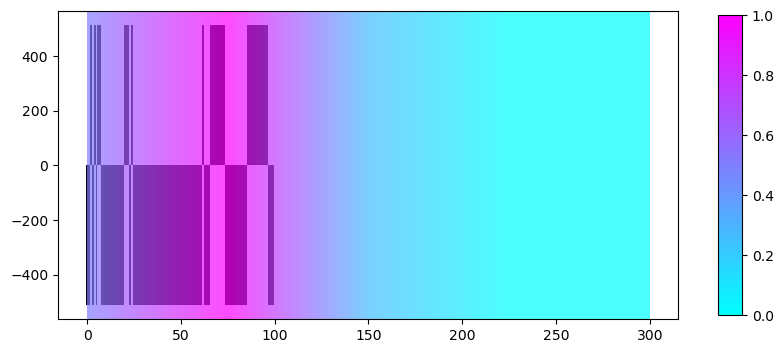

1/1 [==============================] - 0s 23ms/step


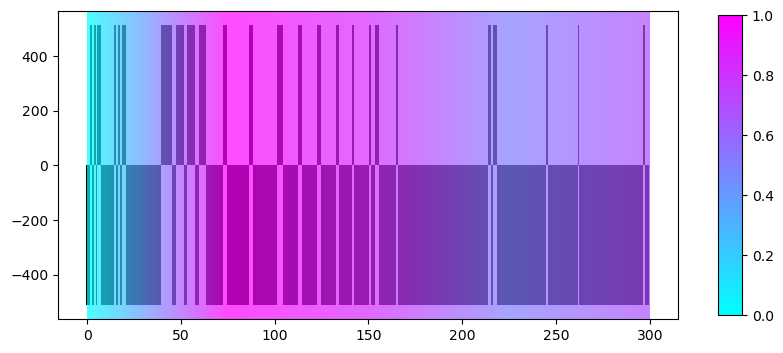

1/1 [==============================] - 0s 24ms/step


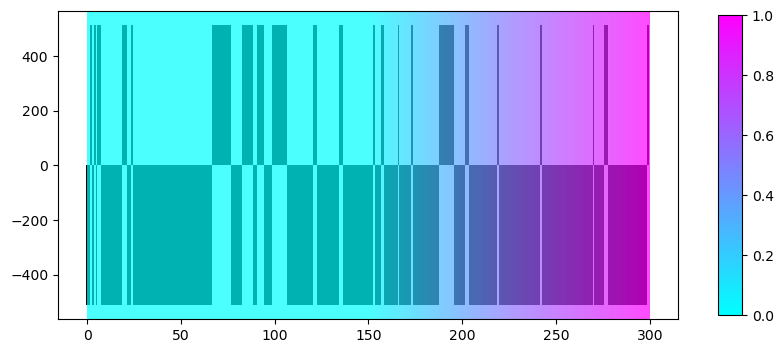

1/1 [==============================] - 0s 24ms/step


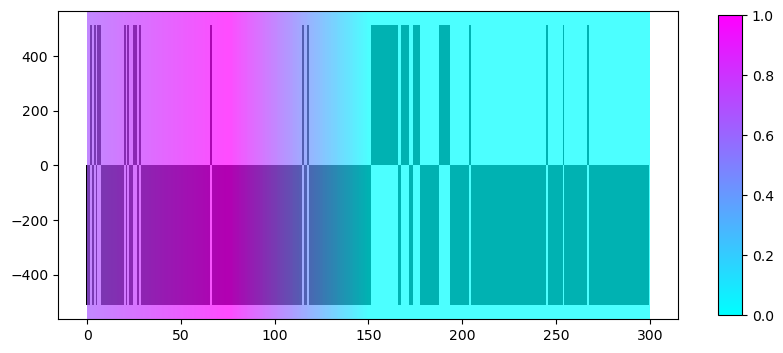

1/1 [==============================] - 0s 23ms/step


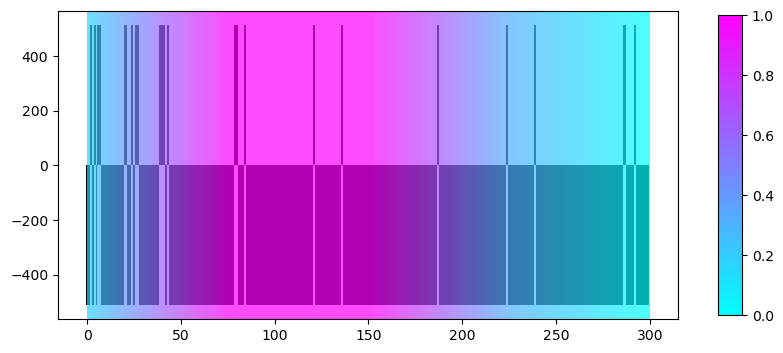

In [111]:
for i in all_idx:
    get_gradcampp(i)

# ExMatchina

In [ ]:
def plot_ecg(test, examples, label):
        # =======GENERATE STUDY EXAMPLES=========
    fig = plt.figure(figsize=(14,5))
    num_display = 4
    fig.add_subplot(1, num_display, 1).title.set_text(inv_class_dict[label])
    plt.plot(test)
   # plt.axis('off')
    line = fig.add_subplot(1, 1, 1)
    line.plot([2.39,2.39],[0,1],'--')
    line.set_xlim(0,10)
    line.axis('off')
    for k in range(num_display-1):
        if k >= len(examples):
            continue
        fig.add_subplot(1,num_display,k+2).title.set_text(inv_class_dict[label])
        fig.add_subplot(1,num_display,k+2).title.set_color('#0067FF')
        plt.plot(examples[k])
       # plt.axis('off')
    
    fig.tight_layout()
    plt.tight_layout()
    plt.show()
    # plt.savefig('./image-' + str(i) + '-example.png', bbox_inches='tight')

In [ ]:
selected_layer = 'Flatten'

exm = ExMatchina(model=model, layer=selected_layer, examples=x_train)

Getting activations...
2737/2737 [==============================] - 5s 2ms/step
Getting labels...
2737/2737 [==============================] - 6s 2ms/step
Generating activation matrix...


1/1 [==============================] - 0s 131ms/step


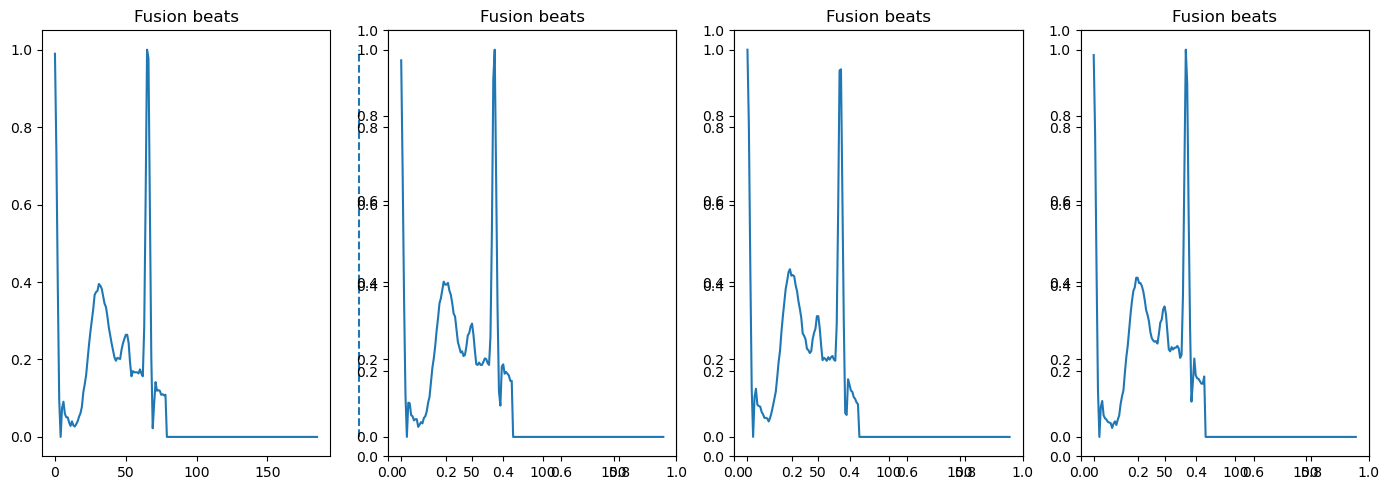

1/1 [==============================] - 0s 125ms/step


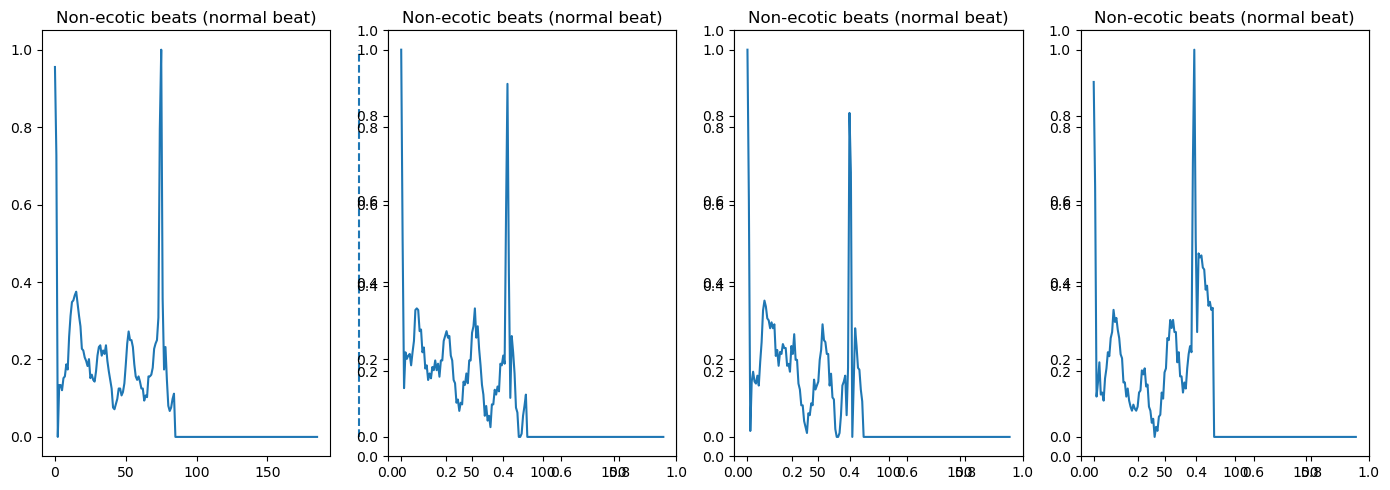

1/1 [==============================] - 0s 127ms/step


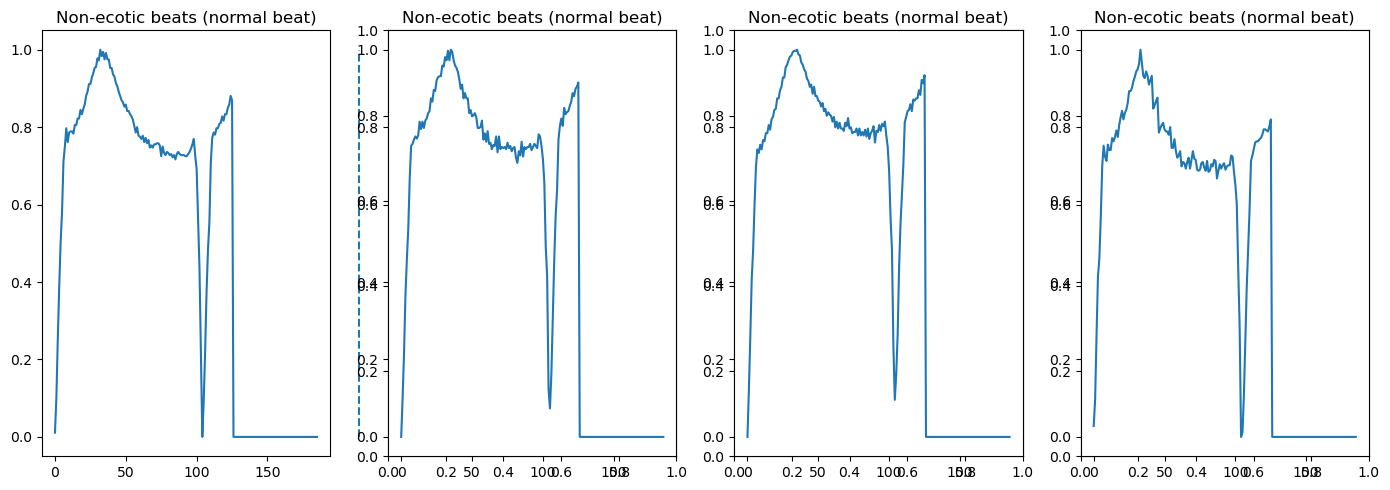

1/1 [==============================] - 0s 126ms/step


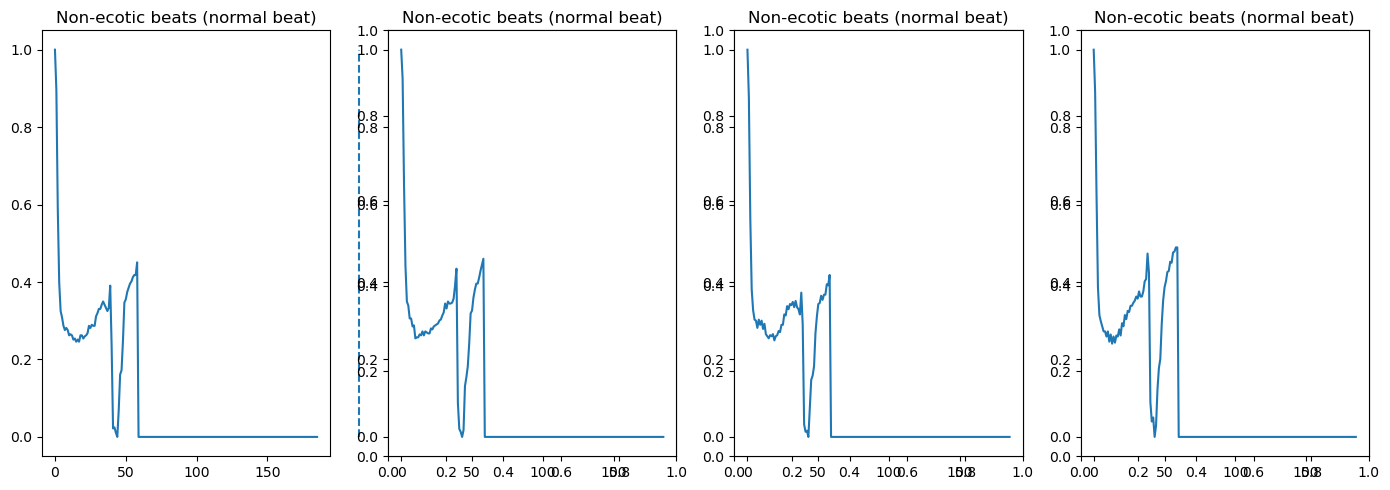

1/1 [==============================] - 0s 127ms/step


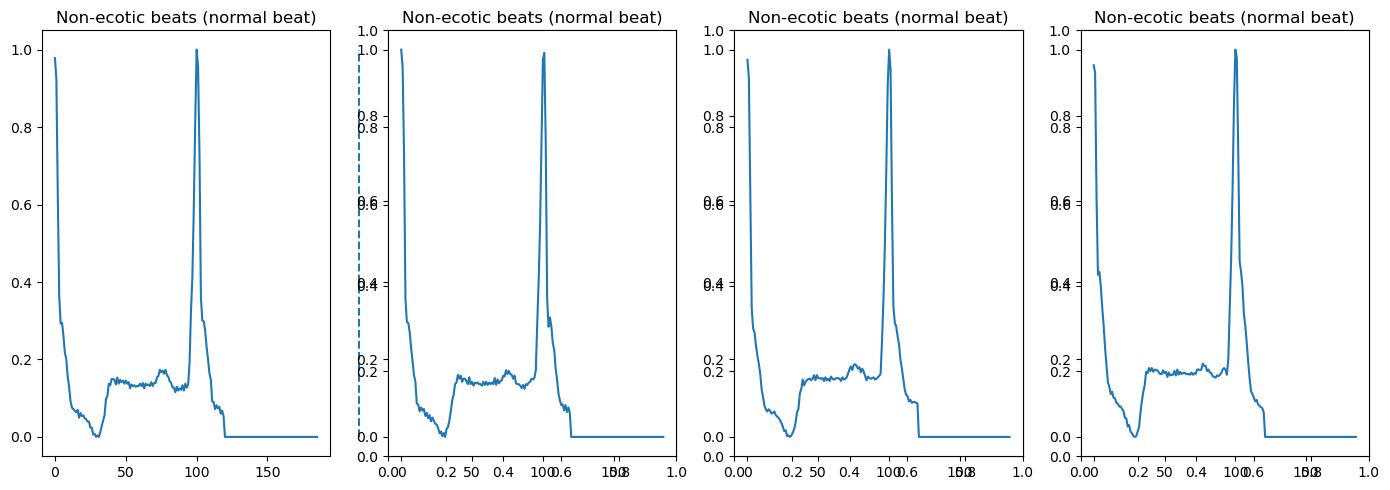

In [ ]:
for test_idx in all_idx:
    test_input = x_test[test_idx]
    label = exm.get_label_for(test_input)
    (examples, indices) = exm.return_nearest_examples(test_input)
    plot_ecg(test_input, examples, label)